In [10]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [11]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [55]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


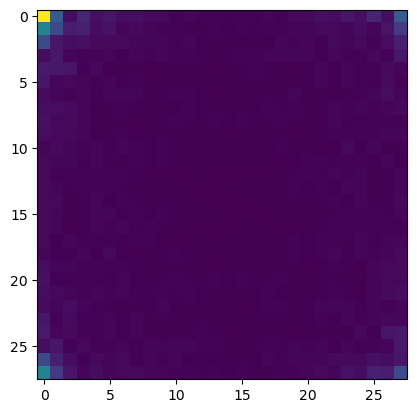

In [56]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [57]:
def phase_shift_fourier(fourier_image, x=2.0, y=2.0):
    """
    Perform a random phase shift on a Fourier-image, constrained by maximum values.
    
    Parameters:
    fourier_image (torch.tensor): Complex-valued centered Fourier representation of an image
    x (float): Maximum amount to shift in x direction (0-2 range recommended due to 2pi periodicity)
    y (float): Maximum amount to shift in y direction (0-2 range recommended due to 2pi periodicity)
    
    Returns:
    torch.tensor: The phase-shifted Fourier-image
    """
    fourier_image = torch.fft.fftshift(fourier_image)
    rows, cols = fourier_image.shape
    
    # Generate random shift amounts within the specified ranges
    random_x = torch.rand(1).item() * x
    random_y = torch.rand(1).item() * y
    shift_x = random_y * torch.pi * rows
    shift_y = random_x * torch.pi * cols
    
    freq_x = torch.fft.fftfreq(cols)
    freq_y = torch.fft.fftfreq(rows)
    fx, fy = torch.meshgrid(freq_x, freq_y, indexing='ij')
    
    # Calculate and apply phase shift
    phase_shift = torch.exp(-1j * (shift_x * fx + shift_y * fy))
    shifted_fourier_image = torch.fft.fftshift(fourier_image * phase_shift)
    
    return shifted_fourier_image

In [58]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        if self.is_training: 
            fft = torch.fft.fftshift(fft)
            fft = phase_shift_fourier(fft)
            fft = torch.fft.fftshift(fft)
            img = torch.fft.ifft2(fft)
        # Duplicate the image along the channel dimension
        img_stacked = torch.stack([img, img])
        
        # Split the complex FFT into real and imaginary parts
        fft_real = torch.real(fft)
        fft_imag = torch.imag(fft)
        fft_stacked = torch.stack([fft_real, fft_imag])
        
        # Stack the image and FFT side by side
        combined = torch.concatenate([img_stacked, fft_stacked], axis=2)
        
        return combined.float()

In [59]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [60]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [61]:
item = next(iter(train_loader))

torch.Size([64, 2, 28, 56])


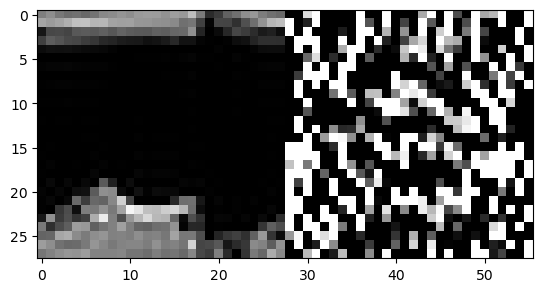

In [63]:
print(item[0].shape)
plt.imshow(item[0][0,1,:,:], cmap="gray", vmin=0, vmax=1)

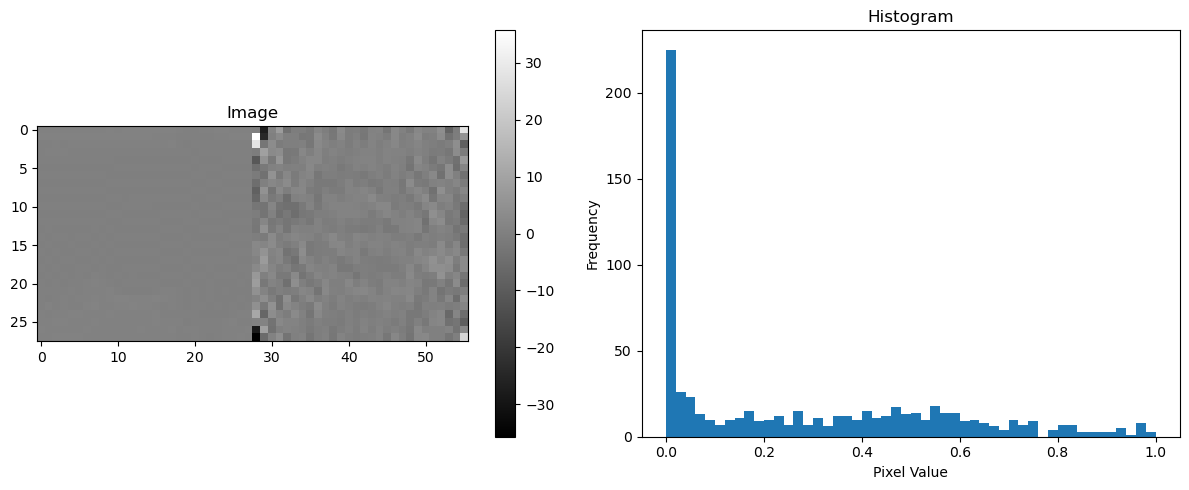

In [64]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [65]:
model = ViT(
    image_size = 56,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 56)

preds = model(img) # (1, 1000)

In [66]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6349774


In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [70]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [72]:


model.to(device)
epochs = 500
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 1: 100%|██████████| 938/938 [01:25<00:00, 10.96batch/s, Train Loss=1.1, Train Acc=58.2] 


Epoch 1
Train Loss: 1.0988, Train Accuracy: 58.16%
Test Loss: 0.8788, Test Accuracy: 67.39%



Epoch 2: 100%|██████████| 938/938 [01:31<00:00, 10.25batch/s, Train Loss=0.752, Train Acc=72.1]


Epoch 2
Train Loss: 0.7519, Train Accuracy: 72.07%
Test Loss: 0.8255, Test Accuracy: 70.84%



Epoch 3: 100%|██████████| 938/938 [01:29<00:00, 10.47batch/s, Train Loss=0.674, Train Acc=74.9]


Epoch 3
Train Loss: 0.6737, Train Accuracy: 74.92%
Test Loss: 0.6971, Test Accuracy: 75.01%



Epoch 4: 100%|██████████| 938/938 [01:31<00:00, 10.27batch/s, Train Loss=0.633, Train Acc=76.7]


Epoch 4
Train Loss: 0.6329, Train Accuracy: 76.74%
Test Loss: 0.6619, Test Accuracy: 76.17%



Epoch 5: 100%|██████████| 938/938 [01:29<00:00, 10.53batch/s, Train Loss=0.596, Train Acc=78.2]


Epoch 5
Train Loss: 0.5958, Train Accuracy: 78.16%
Test Loss: 0.6429, Test Accuracy: 77.42%



Epoch 6: 100%|██████████| 938/938 [01:27<00:00, 10.72batch/s, Train Loss=0.571, Train Acc=78.9]


Epoch 6
Train Loss: 0.5712, Train Accuracy: 78.89%
Test Loss: 0.6735, Test Accuracy: 76.27%



Epoch 7: 100%|██████████| 938/938 [01:31<00:00, 10.21batch/s, Train Loss=0.551, Train Acc=79.7]


Epoch 7
Train Loss: 0.5507, Train Accuracy: 79.66%
Test Loss: 0.5765, Test Accuracy: 79.71%



Epoch 8: 100%|██████████| 938/938 [01:53<00:00,  8.24batch/s, Train Loss=0.528, Train Acc=80.4]


Epoch 8
Train Loss: 0.5280, Train Accuracy: 80.42%
Test Loss: 0.5571, Test Accuracy: 79.90%



Epoch 9: 100%|██████████| 938/938 [01:47<00:00,  8.73batch/s, Train Loss=0.518, Train Acc=80.8]


Epoch 9
Train Loss: 0.5180, Train Accuracy: 80.82%
Test Loss: 0.5469, Test Accuracy: 79.92%



Epoch 10: 100%|██████████| 938/938 [01:47<00:00,  8.70batch/s, Train Loss=0.5, Train Acc=81.6]  


Epoch 10
Train Loss: 0.4996, Train Accuracy: 81.61%
Test Loss: 0.5259, Test Accuracy: 81.64%



Epoch 11: 100%|██████████| 938/938 [01:47<00:00,  8.69batch/s, Train Loss=0.49, Train Acc=82]   


Epoch 11
Train Loss: 0.4903, Train Accuracy: 82.00%
Test Loss: 0.5285, Test Accuracy: 80.86%



Epoch 12: 100%|██████████| 938/938 [01:32<00:00, 10.11batch/s, Train Loss=0.48, Train Acc=82.2] 


Epoch 12
Train Loss: 0.4797, Train Accuracy: 82.24%
Test Loss: 0.4959, Test Accuracy: 82.17%



Epoch 13: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.47, Train Acc=82.7] 


Epoch 13
Train Loss: 0.4698, Train Accuracy: 82.74%
Test Loss: 0.5101, Test Accuracy: 81.92%



Epoch 14: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.461, Train Acc=83.1]


Epoch 14
Train Loss: 0.4607, Train Accuracy: 83.06%
Test Loss: 0.4817, Test Accuracy: 82.39%



Epoch 15: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.451, Train Acc=83.3]


Epoch 15
Train Loss: 0.4512, Train Accuracy: 83.32%
Test Loss: 0.4728, Test Accuracy: 82.97%



Epoch 16: 100%|██████████| 938/938 [01:22<00:00, 11.43batch/s, Train Loss=0.438, Train Acc=83.8]


Epoch 16
Train Loss: 0.4378, Train Accuracy: 83.83%
Test Loss: 0.4851, Test Accuracy: 82.24%



Epoch 17: 100%|██████████| 938/938 [01:22<00:00, 11.44batch/s, Train Loss=0.432, Train Acc=84.1]


Epoch 17
Train Loss: 0.4318, Train Accuracy: 84.07%
Test Loss: 0.4427, Test Accuracy: 83.87%



Epoch 18: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.427, Train Acc=84.2]


Epoch 18
Train Loss: 0.4268, Train Accuracy: 84.17%
Test Loss: 0.4440, Test Accuracy: 84.26%



Epoch 19: 100%|██████████| 938/938 [01:22<00:00, 11.42batch/s, Train Loss=0.418, Train Acc=84.6]


Epoch 19
Train Loss: 0.4183, Train Accuracy: 84.57%
Test Loss: 0.4528, Test Accuracy: 83.93%



Epoch 20: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.415, Train Acc=84.6]


Epoch 20
Train Loss: 0.4153, Train Accuracy: 84.64%
Test Loss: 0.4313, Test Accuracy: 84.60%



Epoch 21: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.41, Train Acc=84.7] 


Epoch 21
Train Loss: 0.4103, Train Accuracy: 84.73%
Test Loss: 0.4303, Test Accuracy: 84.19%



Epoch 22: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.404, Train Acc=85.2]


Epoch 22
Train Loss: 0.4039, Train Accuracy: 85.18%
Test Loss: 0.4274, Test Accuracy: 84.36%



Epoch 23: 100%|██████████| 938/938 [01:22<00:00, 11.42batch/s, Train Loss=0.401, Train Acc=85.3]


Epoch 23
Train Loss: 0.4012, Train Accuracy: 85.30%
Test Loss: 0.4477, Test Accuracy: 83.79%



Epoch 24: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.391, Train Acc=85.6]


Epoch 24
Train Loss: 0.3913, Train Accuracy: 85.58%
Test Loss: 0.4035, Test Accuracy: 85.44%



Epoch 25: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.39, Train Acc=85.5] 


Epoch 25
Train Loss: 0.3895, Train Accuracy: 85.47%
Test Loss: 0.4036, Test Accuracy: 85.08%



Epoch 26: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.385, Train Acc=85.9]


Epoch 26
Train Loss: 0.3854, Train Accuracy: 85.86%
Test Loss: 0.4124, Test Accuracy: 84.96%



Epoch 27: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.384, Train Acc=85.9]


Epoch 27
Train Loss: 0.3835, Train Accuracy: 85.88%
Test Loss: 0.4116, Test Accuracy: 84.52%



Epoch 28: 100%|██████████| 938/938 [01:22<00:00, 11.43batch/s, Train Loss=0.373, Train Acc=86.3]


Epoch 28
Train Loss: 0.3733, Train Accuracy: 86.33%
Test Loss: 0.3941, Test Accuracy: 85.94%



Epoch 29: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.369, Train Acc=86.4]


Epoch 29
Train Loss: 0.3691, Train Accuracy: 86.36%
Test Loss: 0.3836, Test Accuracy: 85.63%



Epoch 30: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.372, Train Acc=86.3]


Epoch 30
Train Loss: 0.3724, Train Accuracy: 86.26%
Test Loss: 0.4065, Test Accuracy: 85.10%



Epoch 31: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.363, Train Acc=86.6]


Epoch 31
Train Loss: 0.3634, Train Accuracy: 86.58%
Test Loss: 0.3842, Test Accuracy: 86.16%



Epoch 32: 100%|██████████| 938/938 [01:22<00:00, 11.40batch/s, Train Loss=0.359, Train Acc=86.8]


Epoch 32
Train Loss: 0.3587, Train Accuracy: 86.75%
Test Loss: 0.3851, Test Accuracy: 86.29%



Epoch 33: 100%|██████████| 938/938 [01:22<00:00, 11.41batch/s, Train Loss=0.356, Train Acc=86.8]


Epoch 33
Train Loss: 0.3559, Train Accuracy: 86.84%
Test Loss: 0.3814, Test Accuracy: 85.80%



Epoch 34: 100%|██████████| 938/938 [01:21<00:00, 11.44batch/s, Train Loss=0.355, Train Acc=86.8]


Epoch 34
Train Loss: 0.3546, Train Accuracy: 86.83%
Test Loss: 0.3961, Test Accuracy: 85.90%



Epoch 35: 100%|██████████| 938/938 [01:22<00:00, 11.41batch/s, Train Loss=0.35, Train Acc=87]   


Epoch 35
Train Loss: 0.3503, Train Accuracy: 87.02%
Test Loss: 0.3878, Test Accuracy: 85.75%



Epoch 36: 100%|██████████| 938/938 [01:25<00:00, 10.97batch/s, Train Loss=0.347, Train Acc=87.1]


Epoch 36
Train Loss: 0.3470, Train Accuracy: 87.12%
Test Loss: 0.3810, Test Accuracy: 86.13%



Epoch 37: 100%|██████████| 938/938 [01:26<00:00, 10.86batch/s, Train Loss=0.342, Train Acc=87.2]


Epoch 37
Train Loss: 0.3423, Train Accuracy: 87.18%
Test Loss: 0.3647, Test Accuracy: 86.66%



Epoch 38: 100%|██████████| 938/938 [01:25<00:00, 10.98batch/s, Train Loss=0.342, Train Acc=87.3]


Epoch 38
Train Loss: 0.3415, Train Accuracy: 87.31%
Test Loss: 0.3628, Test Accuracy: 86.67%



Epoch 39: 100%|██████████| 938/938 [01:24<00:00, 11.16batch/s, Train Loss=0.338, Train Acc=87.4]


Epoch 39
Train Loss: 0.3384, Train Accuracy: 87.41%
Test Loss: 0.3753, Test Accuracy: 86.40%



Epoch 40: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.336, Train Acc=87.5]


Epoch 40
Train Loss: 0.3364, Train Accuracy: 87.54%
Test Loss: 0.3556, Test Accuracy: 87.27%



Epoch 41: 100%|██████████| 938/938 [01:22<00:00, 11.43batch/s, Train Loss=0.332, Train Acc=87.7]


Epoch 41
Train Loss: 0.3319, Train Accuracy: 87.69%
Test Loss: 0.3553, Test Accuracy: 86.93%



Epoch 42: 100%|██████████| 938/938 [01:21<00:00, 11.44batch/s, Train Loss=0.329, Train Acc=87.8]


Epoch 42
Train Loss: 0.3289, Train Accuracy: 87.85%
Test Loss: 0.3646, Test Accuracy: 86.80%



Epoch 43: 100%|██████████| 938/938 [01:22<00:00, 11.30batch/s, Train Loss=0.329, Train Acc=87.8]


Epoch 43
Train Loss: 0.3294, Train Accuracy: 87.84%
Test Loss: 0.3719, Test Accuracy: 86.27%



Epoch 44: 100%|██████████| 938/938 [01:29<00:00, 10.45batch/s, Train Loss=0.325, Train Acc=87.9]


Epoch 44
Train Loss: 0.3251, Train Accuracy: 87.92%
Test Loss: 0.3552, Test Accuracy: 87.05%



Epoch 45: 100%|██████████| 938/938 [01:33<00:00, 10.04batch/s, Train Loss=0.322, Train Acc=88.1]


Epoch 45
Train Loss: 0.3221, Train Accuracy: 88.08%
Test Loss: 0.3661, Test Accuracy: 86.73%



Epoch 46: 100%|██████████| 938/938 [01:26<00:00, 10.86batch/s, Train Loss=0.32, Train Acc=88.1] 


Epoch 46
Train Loss: 0.3201, Train Accuracy: 88.09%
Test Loss: 0.3398, Test Accuracy: 87.46%



Epoch 47: 100%|██████████| 938/938 [01:30<00:00, 10.38batch/s, Train Loss=0.317, Train Acc=88.2]


Epoch 47
Train Loss: 0.3165, Train Accuracy: 88.24%
Test Loss: 0.3484, Test Accuracy: 87.49%



Epoch 48: 100%|██████████| 938/938 [01:26<00:00, 10.83batch/s, Train Loss=0.317, Train Acc=88.1]


Epoch 48
Train Loss: 0.3172, Train Accuracy: 88.12%
Test Loss: 0.3447, Test Accuracy: 87.37%



Epoch 49: 100%|██████████| 938/938 [01:23<00:00, 11.19batch/s, Train Loss=0.314, Train Acc=88.4]


Epoch 49
Train Loss: 0.3140, Train Accuracy: 88.37%
Test Loss: 0.3554, Test Accuracy: 86.56%



Epoch 50: 100%|██████████| 938/938 [01:53<00:00,  8.26batch/s, Train Loss=0.312, Train Acc=88.3]


Epoch 50
Train Loss: 0.3119, Train Accuracy: 88.33%
Test Loss: 0.3482, Test Accuracy: 86.91%



Epoch 51: 100%|██████████| 938/938 [01:53<00:00,  8.27batch/s, Train Loss=0.312, Train Acc=88.4]


Epoch 51
Train Loss: 0.3125, Train Accuracy: 88.43%
Test Loss: 0.3301, Test Accuracy: 87.76%



Epoch 52: 100%|██████████| 938/938 [01:53<00:00,  8.30batch/s, Train Loss=0.305, Train Acc=88.6]


Epoch 52
Train Loss: 0.3053, Train Accuracy: 88.57%
Test Loss: 0.3249, Test Accuracy: 87.91%



Epoch 53: 100%|██████████| 938/938 [01:53<00:00,  8.29batch/s, Train Loss=0.306, Train Acc=88.6]


Epoch 53
Train Loss: 0.3065, Train Accuracy: 88.65%
Test Loss: 0.3307, Test Accuracy: 87.64%



Epoch 54: 100%|██████████| 938/938 [01:53<00:00,  8.28batch/s, Train Loss=0.304, Train Acc=88.6]


Epoch 54
Train Loss: 0.3045, Train Accuracy: 88.65%
Test Loss: 0.3280, Test Accuracy: 87.85%



Epoch 55: 100%|██████████| 938/938 [01:54<00:00,  8.20batch/s, Train Loss=0.301, Train Acc=88.9]


Epoch 55
Train Loss: 0.3007, Train Accuracy: 88.86%
Test Loss: 0.3365, Test Accuracy: 87.69%



Epoch 56: 100%|██████████| 938/938 [01:52<00:00,  8.32batch/s, Train Loss=0.299, Train Acc=88.8]


Epoch 56
Train Loss: 0.2990, Train Accuracy: 88.83%
Test Loss: 0.3281, Test Accuracy: 88.14%



Epoch 57: 100%|██████████| 938/938 [01:52<00:00,  8.32batch/s, Train Loss=0.298, Train Acc=88.9]


Epoch 57
Train Loss: 0.2983, Train Accuracy: 88.89%
Test Loss: 0.3208, Test Accuracy: 88.44%



Epoch 58: 100%|██████████| 938/938 [01:53<00:00,  8.28batch/s, Train Loss=0.295, Train Acc=88.9]


Epoch 58
Train Loss: 0.2951, Train Accuracy: 88.94%
Test Loss: 0.3166, Test Accuracy: 88.43%



Epoch 59: 100%|██████████| 938/938 [01:49<00:00,  8.55batch/s, Train Loss=0.295, Train Acc=88.9]


Epoch 59
Train Loss: 0.2951, Train Accuracy: 88.88%
Test Loss: 0.3174, Test Accuracy: 88.30%



Epoch 60: 100%|██████████| 938/938 [01:51<00:00,  8.44batch/s, Train Loss=0.291, Train Acc=89.1]


Epoch 60
Train Loss: 0.2913, Train Accuracy: 89.12%
Test Loss: 0.3130, Test Accuracy: 88.53%



Epoch 61: 100%|██████████| 938/938 [01:50<00:00,  8.49batch/s, Train Loss=0.293, Train Acc=88.9]


Epoch 61
Train Loss: 0.2930, Train Accuracy: 88.89%
Test Loss: 0.3215, Test Accuracy: 88.35%



Epoch 62: 100%|██████████| 938/938 [01:50<00:00,  8.45batch/s, Train Loss=0.29, Train Acc=89.2] 


Epoch 62
Train Loss: 0.2902, Train Accuracy: 89.21%
Test Loss: 0.3170, Test Accuracy: 88.39%



Epoch 63: 100%|██████████| 938/938 [01:51<00:00,  8.40batch/s, Train Loss=0.286, Train Acc=89.3]


Epoch 63
Train Loss: 0.2860, Train Accuracy: 89.34%
Test Loss: 0.3204, Test Accuracy: 88.26%



Epoch 64: 100%|██████████| 938/938 [01:53<00:00,  8.23batch/s, Train Loss=0.286, Train Acc=89.3]


Epoch 64
Train Loss: 0.2864, Train Accuracy: 89.28%
Test Loss: 0.3190, Test Accuracy: 88.45%



Epoch 65: 100%|██████████| 938/938 [01:55<00:00,  8.14batch/s, Train Loss=0.286, Train Acc=89.3]


Epoch 65
Train Loss: 0.2864, Train Accuracy: 89.26%
Test Loss: 0.3094, Test Accuracy: 88.69%



Epoch 66: 100%|██████████| 938/938 [01:52<00:00,  8.35batch/s, Train Loss=0.283, Train Acc=89.4]


Epoch 66
Train Loss: 0.2834, Train Accuracy: 89.36%
Test Loss: 0.3137, Test Accuracy: 88.62%



Epoch 67: 100%|██████████| 938/938 [01:52<00:00,  8.36batch/s, Train Loss=0.283, Train Acc=89.4]


Epoch 67
Train Loss: 0.2826, Train Accuracy: 89.43%
Test Loss: 0.3204, Test Accuracy: 88.64%



Epoch 68: 100%|██████████| 938/938 [01:52<00:00,  8.33batch/s, Train Loss=0.278, Train Acc=89.6]


Epoch 68
Train Loss: 0.2781, Train Accuracy: 89.55%
Test Loss: 0.3071, Test Accuracy: 88.93%



Epoch 69: 100%|██████████| 938/938 [01:51<00:00,  8.44batch/s, Train Loss=0.278, Train Acc=89.6]


Epoch 69
Train Loss: 0.2781, Train Accuracy: 89.64%
Test Loss: 0.3028, Test Accuracy: 88.81%



Epoch 70: 100%|██████████| 938/938 [01:50<00:00,  8.47batch/s, Train Loss=0.276, Train Acc=89.7]


Epoch 70
Train Loss: 0.2757, Train Accuracy: 89.72%
Test Loss: 0.3161, Test Accuracy: 88.49%



Epoch 71: 100%|██████████| 938/938 [01:49<00:00,  8.54batch/s, Train Loss=0.275, Train Acc=89.6]


Epoch 71
Train Loss: 0.2749, Train Accuracy: 89.63%
Test Loss: 0.3100, Test Accuracy: 88.61%



Epoch 72: 100%|██████████| 938/938 [01:51<00:00,  8.42batch/s, Train Loss=0.276, Train Acc=89.7]


Epoch 72
Train Loss: 0.2756, Train Accuracy: 89.71%
Test Loss: 0.2968, Test Accuracy: 89.00%



Epoch 73: 100%|██████████| 938/938 [01:52<00:00,  8.35batch/s, Train Loss=0.273, Train Acc=89.8]


Epoch 73
Train Loss: 0.2728, Train Accuracy: 89.84%
Test Loss: 0.2971, Test Accuracy: 89.16%



Epoch 74: 100%|██████████| 938/938 [01:55<00:00,  8.15batch/s, Train Loss=0.27, Train Acc=90]   


Epoch 74
Train Loss: 0.2703, Train Accuracy: 89.98%
Test Loss: 0.3022, Test Accuracy: 88.90%



Epoch 75: 100%|██████████| 938/938 [01:54<00:00,  8.16batch/s, Train Loss=0.269, Train Acc=89.9]


Epoch 75
Train Loss: 0.2691, Train Accuracy: 89.89%
Test Loss: 0.2915, Test Accuracy: 89.28%



Epoch 76: 100%|██████████| 938/938 [01:51<00:00,  8.43batch/s, Train Loss=0.269, Train Acc=90]  


Epoch 76
Train Loss: 0.2687, Train Accuracy: 89.95%
Test Loss: 0.3067, Test Accuracy: 89.06%



Epoch 77: 100%|██████████| 938/938 [01:50<00:00,  8.50batch/s, Train Loss=0.27, Train Acc=90]   


Epoch 77
Train Loss: 0.2698, Train Accuracy: 89.95%
Test Loss: 0.2902, Test Accuracy: 89.30%



Epoch 78: 100%|██████████| 938/938 [01:52<00:00,  8.33batch/s, Train Loss=0.266, Train Acc=89.9]


Epoch 78
Train Loss: 0.2661, Train Accuracy: 89.89%
Test Loss: 0.3017, Test Accuracy: 89.12%



Epoch 79: 100%|██████████| 938/938 [01:54<00:00,  8.23batch/s, Train Loss=0.265, Train Acc=90.1]


Epoch 79
Train Loss: 0.2648, Train Accuracy: 90.12%
Test Loss: 0.3053, Test Accuracy: 89.08%



Epoch 80: 100%|██████████| 938/938 [01:52<00:00,  8.31batch/s, Train Loss=0.265, Train Acc=90]  


Epoch 80
Train Loss: 0.2650, Train Accuracy: 90.00%
Test Loss: 0.3033, Test Accuracy: 88.79%



Epoch 81: 100%|██████████| 938/938 [01:50<00:00,  8.45batch/s, Train Loss=0.263, Train Acc=90.2]


Epoch 81
Train Loss: 0.2629, Train Accuracy: 90.18%
Test Loss: 0.3000, Test Accuracy: 89.05%



Epoch 82: 100%|██████████| 938/938 [01:51<00:00,  8.38batch/s, Train Loss=0.261, Train Acc=90.1]


Epoch 82
Train Loss: 0.2610, Train Accuracy: 90.14%
Test Loss: 0.3006, Test Accuracy: 88.98%



Epoch 83: 100%|██████████| 938/938 [01:54<00:00,  8.23batch/s, Train Loss=0.259, Train Acc=90.2]


Epoch 83
Train Loss: 0.2595, Train Accuracy: 90.25%
Test Loss: 0.2918, Test Accuracy: 89.20%



Epoch 84: 100%|██████████| 938/938 [01:58<00:00,  7.91batch/s, Train Loss=0.259, Train Acc=90.3]


Epoch 84
Train Loss: 0.2593, Train Accuracy: 90.32%
Test Loss: 0.2814, Test Accuracy: 89.45%



Epoch 85: 100%|██████████| 938/938 [01:55<00:00,  8.09batch/s, Train Loss=0.258, Train Acc=90.3]


Epoch 85
Train Loss: 0.2578, Train Accuracy: 90.32%
Test Loss: 0.2779, Test Accuracy: 89.72%



Epoch 86: 100%|██████████| 938/938 [01:52<00:00,  8.36batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 86
Train Loss: 0.2565, Train Accuracy: 90.33%
Test Loss: 0.2905, Test Accuracy: 89.16%



Epoch 87: 100%|██████████| 938/938 [01:50<00:00,  8.51batch/s, Train Loss=0.256, Train Acc=90.4]


Epoch 87
Train Loss: 0.2558, Train Accuracy: 90.43%
Test Loss: 0.2863, Test Accuracy: 89.35%



Epoch 88: 100%|██████████| 938/938 [01:51<00:00,  8.41batch/s, Train Loss=0.254, Train Acc=90.5]


Epoch 88
Train Loss: 0.2542, Train Accuracy: 90.51%
Test Loss: 0.2888, Test Accuracy: 89.54%



Epoch 89: 100%|██████████| 938/938 [01:50<00:00,  8.50batch/s, Train Loss=0.254, Train Acc=90.6]


Epoch 89
Train Loss: 0.2542, Train Accuracy: 90.56%
Test Loss: 0.2888, Test Accuracy: 89.58%



Epoch 90: 100%|██████████| 938/938 [01:50<00:00,  8.45batch/s, Train Loss=0.254, Train Acc=90.5]


Epoch 90
Train Loss: 0.2537, Train Accuracy: 90.54%
Test Loss: 0.2951, Test Accuracy: 89.10%



Epoch 91: 100%|██████████| 938/938 [01:51<00:00,  8.40batch/s, Train Loss=0.252, Train Acc=90.5]


Epoch 91
Train Loss: 0.2522, Train Accuracy: 90.51%
Test Loss: 0.2854, Test Accuracy: 89.36%



Epoch 92: 100%|██████████| 938/938 [01:51<00:00,  8.43batch/s, Train Loss=0.251, Train Acc=90.5]


Epoch 92
Train Loss: 0.2512, Train Accuracy: 90.54%
Test Loss: 0.2800, Test Accuracy: 89.53%



Epoch 93: 100%|██████████| 938/938 [01:53<00:00,  8.29batch/s, Train Loss=0.248, Train Acc=90.7]


Epoch 93
Train Loss: 0.2481, Train Accuracy: 90.75%
Test Loss: 0.2801, Test Accuracy: 89.75%



Epoch 94: 100%|██████████| 938/938 [01:52<00:00,  8.33batch/s, Train Loss=0.248, Train Acc=90.7]


Epoch 94
Train Loss: 0.2484, Train Accuracy: 90.75%
Test Loss: 0.2834, Test Accuracy: 89.61%



Epoch 95: 100%|██████████| 938/938 [01:54<00:00,  8.20batch/s, Train Loss=0.246, Train Acc=90.8]


Epoch 95
Train Loss: 0.2463, Train Accuracy: 90.75%
Test Loss: 0.2823, Test Accuracy: 89.57%



Epoch 96: 100%|██████████| 938/938 [01:50<00:00,  8.50batch/s, Train Loss=0.246, Train Acc=90.8]


Epoch 96
Train Loss: 0.2455, Train Accuracy: 90.81%
Test Loss: 0.2853, Test Accuracy: 89.64%



Epoch 97: 100%|██████████| 938/938 [01:57<00:00,  7.99batch/s, Train Loss=0.245, Train Acc=90.9]


Epoch 97
Train Loss: 0.2452, Train Accuracy: 90.89%
Test Loss: 0.2849, Test Accuracy: 89.50%



Epoch 98: 100%|██████████| 938/938 [01:51<00:00,  8.40batch/s, Train Loss=0.244, Train Acc=90.8]


Epoch 98
Train Loss: 0.2438, Train Accuracy: 90.82%
Test Loss: 0.2820, Test Accuracy: 89.69%



Epoch 99: 100%|██████████| 938/938 [01:50<00:00,  8.48batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 99
Train Loss: 0.2450, Train Accuracy: 90.67%
Test Loss: 0.2786, Test Accuracy: 90.04%



Epoch 100: 100%|██████████| 938/938 [01:50<00:00,  8.49batch/s, Train Loss=0.242, Train Acc=90.9]


Epoch 100
Train Loss: 0.2416, Train Accuracy: 90.94%
Test Loss: 0.2745, Test Accuracy: 89.67%



Epoch 101: 100%|██████████| 938/938 [01:51<00:00,  8.44batch/s, Train Loss=0.241, Train Acc=91]  


Epoch 101
Train Loss: 0.2405, Train Accuracy: 91.00%
Test Loss: 0.2857, Test Accuracy: 89.37%



Epoch 102: 100%|██████████| 938/938 [01:50<00:00,  8.50batch/s, Train Loss=0.241, Train Acc=90.9]


Epoch 102
Train Loss: 0.2413, Train Accuracy: 90.88%
Test Loss: 0.2872, Test Accuracy: 89.53%



Epoch 103: 100%|██████████| 938/938 [01:50<00:00,  8.52batch/s, Train Loss=0.241, Train Acc=91]  


Epoch 103
Train Loss: 0.2411, Train Accuracy: 90.97%
Test Loss: 0.2854, Test Accuracy: 89.39%



Epoch 104: 100%|██████████| 938/938 [01:50<00:00,  8.49batch/s, Train Loss=0.239, Train Acc=91.1]


Epoch 104
Train Loss: 0.2391, Train Accuracy: 91.08%
Test Loss: 0.2841, Test Accuracy: 89.96%



Epoch 105: 100%|██████████| 938/938 [01:47<00:00,  8.73batch/s, Train Loss=0.237, Train Acc=91.1]


Epoch 105
Train Loss: 0.2368, Train Accuracy: 91.06%
Test Loss: 0.2817, Test Accuracy: 90.11%



Epoch 106: 100%|██████████| 938/938 [01:27<00:00, 10.71batch/s, Train Loss=0.236, Train Acc=91.1]


Epoch 106
Train Loss: 0.2364, Train Accuracy: 91.12%
Test Loss: 0.2750, Test Accuracy: 89.99%



Epoch 107: 100%|██████████| 938/938 [01:22<00:00, 11.44batch/s, Train Loss=0.236, Train Acc=91.1]


Epoch 107
Train Loss: 0.2364, Train Accuracy: 91.10%
Test Loss: 0.2760, Test Accuracy: 89.75%



Epoch 108: 100%|██████████| 938/938 [01:21<00:00, 11.51batch/s, Train Loss=0.234, Train Acc=91.3]


Epoch 108
Train Loss: 0.2341, Train Accuracy: 91.31%
Test Loss: 0.2793, Test Accuracy: 89.97%



Epoch 109: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 109
Train Loss: 0.2342, Train Accuracy: 91.13%
Test Loss: 0.2718, Test Accuracy: 89.89%



Epoch 110: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 110
Train Loss: 0.2341, Train Accuracy: 91.14%
Test Loss: 0.2745, Test Accuracy: 90.07%



Epoch 111: 100%|██████████| 938/938 [01:21<00:00, 11.50batch/s, Train Loss=0.228, Train Acc=91.4]


Epoch 111
Train Loss: 0.2280, Train Accuracy: 91.40%
Test Loss: 0.2712, Test Accuracy: 90.07%



Epoch 112: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.23, Train Acc=91.3] 


Epoch 112
Train Loss: 0.2297, Train Accuracy: 91.30%
Test Loss: 0.2753, Test Accuracy: 90.06%



Epoch 113: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 113
Train Loss: 0.2314, Train Accuracy: 91.24%
Test Loss: 0.2744, Test Accuracy: 89.88%



Epoch 114: 100%|██████████| 938/938 [01:22<00:00, 11.43batch/s, Train Loss=0.228, Train Acc=91.4]


Epoch 114
Train Loss: 0.2281, Train Accuracy: 91.39%
Test Loss: 0.2637, Test Accuracy: 90.31%



Epoch 115: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.226, Train Acc=91.5]


Epoch 115
Train Loss: 0.2256, Train Accuracy: 91.48%
Test Loss: 0.2698, Test Accuracy: 89.93%



Epoch 116: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.228, Train Acc=91.5]


Epoch 116
Train Loss: 0.2279, Train Accuracy: 91.46%
Test Loss: 0.2656, Test Accuracy: 90.01%



Epoch 117: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.225, Train Acc=91.5]


Epoch 117
Train Loss: 0.2254, Train Accuracy: 91.53%
Test Loss: 0.2757, Test Accuracy: 89.92%



Epoch 118: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.228, Train Acc=91.4]


Epoch 118
Train Loss: 0.2278, Train Accuracy: 91.44%
Test Loss: 0.2686, Test Accuracy: 90.17%



Epoch 119: 100%|██████████| 938/938 [01:22<00:00, 11.42batch/s, Train Loss=0.225, Train Acc=91.5]


Epoch 119
Train Loss: 0.2252, Train Accuracy: 91.54%
Test Loss: 0.2661, Test Accuracy: 90.31%



Epoch 120: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.223, Train Acc=91.6]


Epoch 120
Train Loss: 0.2231, Train Accuracy: 91.62%
Test Loss: 0.2686, Test Accuracy: 90.10%



Epoch 121: 100%|██████████| 938/938 [01:21<00:00, 11.44batch/s, Train Loss=0.228, Train Acc=91.3]


Epoch 121
Train Loss: 0.2280, Train Accuracy: 91.33%
Test Loss: 0.2766, Test Accuracy: 89.93%



Epoch 122: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 122
Train Loss: 0.2202, Train Accuracy: 91.63%
Test Loss: 0.2618, Test Accuracy: 90.53%



Epoch 123: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.222, Train Acc=91.6]


Epoch 123
Train Loss: 0.2222, Train Accuracy: 91.64%
Test Loss: 0.2643, Test Accuracy: 90.34%



Epoch 124: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.221, Train Acc=91.6]


Epoch 124
Train Loss: 0.2211, Train Accuracy: 91.62%
Test Loss: 0.2617, Test Accuracy: 90.50%



Epoch 125: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.221, Train Acc=91.7]


Epoch 125
Train Loss: 0.2205, Train Accuracy: 91.69%
Test Loss: 0.2663, Test Accuracy: 90.54%



Epoch 126: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.221, Train Acc=91.7]


Epoch 126
Train Loss: 0.2210, Train Accuracy: 91.74%
Test Loss: 0.2642, Test Accuracy: 90.48%



Epoch 127: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.218, Train Acc=91.8]


Epoch 127
Train Loss: 0.2182, Train Accuracy: 91.81%
Test Loss: 0.2679, Test Accuracy: 90.45%



Epoch 128: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.221, Train Acc=91.7]


Epoch 128
Train Loss: 0.2207, Train Accuracy: 91.67%
Test Loss: 0.2612, Test Accuracy: 90.56%



Epoch 129: 100%|██████████| 938/938 [01:22<00:00, 11.41batch/s, Train Loss=0.219, Train Acc=91.7]


Epoch 129
Train Loss: 0.2194, Train Accuracy: 91.68%
Test Loss: 0.2647, Test Accuracy: 90.13%



Epoch 130: 100%|██████████| 938/938 [01:22<00:00, 11.41batch/s, Train Loss=0.217, Train Acc=91.9]


Epoch 130
Train Loss: 0.2170, Train Accuracy: 91.86%
Test Loss: 0.2696, Test Accuracy: 90.32%



Epoch 131: 100%|██████████| 938/938 [01:21<00:00, 11.44batch/s, Train Loss=0.216, Train Acc=91.8]


Epoch 131
Train Loss: 0.2160, Train Accuracy: 91.77%
Test Loss: 0.2618, Test Accuracy: 90.63%



Epoch 132: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.214, Train Acc=91.9]


Epoch 132
Train Loss: 0.2137, Train Accuracy: 91.88%
Test Loss: 0.2608, Test Accuracy: 90.56%



Epoch 133: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.216, Train Acc=91.8]


Epoch 133
Train Loss: 0.2159, Train Accuracy: 91.80%
Test Loss: 0.2584, Test Accuracy: 90.43%



Epoch 134: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.213, Train Acc=92]  


Epoch 134
Train Loss: 0.2132, Train Accuracy: 91.96%
Test Loss: 0.2655, Test Accuracy: 90.46%



Epoch 135: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.212, Train Acc=92]  


Epoch 135
Train Loss: 0.2121, Train Accuracy: 92.00%
Test Loss: 0.2550, Test Accuracy: 90.63%



Epoch 136: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.212, Train Acc=92]  


Epoch 136
Train Loss: 0.2119, Train Accuracy: 92.00%
Test Loss: 0.2812, Test Accuracy: 89.83%



Epoch 137: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 137
Train Loss: 0.2120, Train Accuracy: 91.87%
Test Loss: 0.2484, Test Accuracy: 90.90%



Epoch 138: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.21, Train Acc=92]   


Epoch 138
Train Loss: 0.2102, Train Accuracy: 91.97%
Test Loss: 0.2596, Test Accuracy: 90.48%



Epoch 139: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.211, Train Acc=92.1]


Epoch 139
Train Loss: 0.2109, Train Accuracy: 92.09%
Test Loss: 0.2637, Test Accuracy: 90.50%



Epoch 140: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.21, Train Acc=92.1] 


Epoch 140
Train Loss: 0.2095, Train Accuracy: 92.12%
Test Loss: 0.2570, Test Accuracy: 90.64%



Epoch 141: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 141
Train Loss: 0.2112, Train Accuracy: 91.99%
Test Loss: 0.2572, Test Accuracy: 90.82%



Epoch 142: 100%|██████████| 938/938 [01:21<00:00, 11.50batch/s, Train Loss=0.207, Train Acc=92.2]


Epoch 142
Train Loss: 0.2074, Train Accuracy: 92.16%
Test Loss: 0.2583, Test Accuracy: 90.81%



Epoch 143: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 143
Train Loss: 0.2079, Train Accuracy: 92.10%
Test Loss: 0.2510, Test Accuracy: 90.76%



Epoch 144: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.205, Train Acc=92.3]


Epoch 144
Train Loss: 0.2046, Train Accuracy: 92.30%
Test Loss: 0.2618, Test Accuracy: 90.27%



Epoch 145: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.205, Train Acc=92.2]


Epoch 145
Train Loss: 0.2054, Train Accuracy: 92.15%
Test Loss: 0.2580, Test Accuracy: 90.76%



Epoch 146: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.206, Train Acc=92.2]


Epoch 146
Train Loss: 0.2058, Train Accuracy: 92.20%
Test Loss: 0.2572, Test Accuracy: 90.71%



Epoch 147: 100%|██████████| 938/938 [01:21<00:00, 11.44batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 147
Train Loss: 0.2077, Train Accuracy: 92.14%
Test Loss: 0.2586, Test Accuracy: 90.77%



Epoch 148: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.205, Train Acc=92.2]


Epoch 148
Train Loss: 0.2049, Train Accuracy: 92.22%
Test Loss: 0.2574, Test Accuracy: 90.63%



Epoch 149: 100%|██████████| 938/938 [01:21<00:00, 11.50batch/s, Train Loss=0.202, Train Acc=92.5]


Epoch 149
Train Loss: 0.2022, Train Accuracy: 92.45%
Test Loss: 0.2494, Test Accuracy: 91.02%



Epoch 150: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.204, Train Acc=92.3]


Epoch 150
Train Loss: 0.2037, Train Accuracy: 92.35%
Test Loss: 0.2577, Test Accuracy: 90.37%



Epoch 151: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.201, Train Acc=92.5]


Epoch 151
Train Loss: 0.2008, Train Accuracy: 92.49%
Test Loss: 0.2508, Test Accuracy: 90.74%



Epoch 152: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, Train Loss=0.202, Train Acc=92.5]


Epoch 152
Train Loss: 0.2015, Train Accuracy: 92.48%
Test Loss: 0.2599, Test Accuracy: 90.54%



Epoch 153: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.201, Train Acc=92.4]


Epoch 153
Train Loss: 0.2014, Train Accuracy: 92.40%
Test Loss: 0.2579, Test Accuracy: 90.73%



Epoch 154: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 154
Train Loss: 0.1991, Train Accuracy: 92.42%
Test Loss: 0.2474, Test Accuracy: 91.08%



Epoch 155: 100%|██████████| 938/938 [01:21<00:00, 11.52batch/s, Train Loss=0.201, Train Acc=92.3]


Epoch 155
Train Loss: 0.2012, Train Accuracy: 92.34%
Test Loss: 0.2538, Test Accuracy: 90.73%



Epoch 156: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 156
Train Loss: 0.1986, Train Accuracy: 92.44%
Test Loss: 0.2571, Test Accuracy: 90.76%



Epoch 157: 100%|██████████| 938/938 [01:21<00:00, 11.50batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 157
Train Loss: 0.1992, Train Accuracy: 92.36%
Test Loss: 0.2580, Test Accuracy: 90.74%



Epoch 158: 100%|██████████| 938/938 [01:21<00:00, 11.46batch/s, Train Loss=0.197, Train Acc=92.6]


Epoch 158
Train Loss: 0.1966, Train Accuracy: 92.61%
Test Loss: 0.2495, Test Accuracy: 90.81%



Epoch 159: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 159
Train Loss: 0.1961, Train Accuracy: 92.53%
Test Loss: 0.2542, Test Accuracy: 90.88%



Epoch 160: 100%|██████████| 938/938 [01:21<00:00, 11.49batch/s, Train Loss=0.197, Train Acc=92.6]


Epoch 160
Train Loss: 0.1966, Train Accuracy: 92.58%
Test Loss: 0.2493, Test Accuracy: 91.04%



Epoch 161: 100%|██████████| 938/938 [01:21<00:00, 11.48batch/s, Train Loss=0.196, Train Acc=92.6]


Epoch 161
Train Loss: 0.1959, Train Accuracy: 92.61%
Test Loss: 0.2482, Test Accuracy: 91.17%



Epoch 162: 100%|██████████| 938/938 [01:22<00:00, 11.43batch/s, Train Loss=0.196, Train Acc=92.7]


Epoch 162
Train Loss: 0.1964, Train Accuracy: 92.67%
Test Loss: 0.2479, Test Accuracy: 91.00%



Epoch 163: 100%|██████████| 938/938 [01:21<00:00, 11.50batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 163
Train Loss: 0.1957, Train Accuracy: 92.51%
Test Loss: 0.2505, Test Accuracy: 90.92%



Epoch 164: 100%|██████████| 938/938 [01:21<00:00, 11.52batch/s, Train Loss=0.193, Train Acc=92.6]


Epoch 164
Train Loss: 0.1930, Train Accuracy: 92.56%
Test Loss: 0.2497, Test Accuracy: 90.85%



Epoch 165: 100%|██████████| 938/938 [01:21<00:00, 11.45batch/s, Train Loss=0.192, Train Acc=92.8]


Epoch 165
Train Loss: 0.1920, Train Accuracy: 92.77%
Test Loss: 0.2478, Test Accuracy: 91.05%



Epoch 166: 100%|██████████| 938/938 [01:27<00:00, 10.74batch/s, Train Loss=0.191, Train Acc=92.7]


Epoch 166
Train Loss: 0.1913, Train Accuracy: 92.73%
Test Loss: 0.2448, Test Accuracy: 91.16%



Epoch 167: 100%|██████████| 938/938 [01:30<00:00, 10.39batch/s, Train Loss=0.194, Train Acc=92.7]


Epoch 167
Train Loss: 0.1936, Train Accuracy: 92.72%
Test Loss: 0.2572, Test Accuracy: 90.42%



Epoch 168: 100%|██████████| 938/938 [01:25<00:00, 10.92batch/s, Train Loss=0.188, Train Acc=92.8]


Epoch 168
Train Loss: 0.1882, Train Accuracy: 92.78%
Test Loss: 0.2589, Test Accuracy: 90.94%



Epoch 169: 100%|██████████| 938/938 [01:57<00:00,  7.99batch/s, Train Loss=0.192, Train Acc=92.8]


Epoch 169
Train Loss: 0.1917, Train Accuracy: 92.80%
Test Loss: 0.2417, Test Accuracy: 90.91%



Epoch 170: 100%|██████████| 938/938 [03:19<00:00,  4.69batch/s, Train Loss=0.191, Train Acc=92.8]


Epoch 170
Train Loss: 0.1910, Train Accuracy: 92.78%
Test Loss: 0.2579, Test Accuracy: 90.51%



Epoch 171: 100%|██████████| 938/938 [05:11<00:00,  3.01batch/s, Train Loss=0.189, Train Acc=92.8]


Epoch 171
Train Loss: 0.1890, Train Accuracy: 92.78%
Test Loss: 0.2459, Test Accuracy: 91.07%



Epoch 172: 100%|██████████| 938/938 [05:48<00:00,  2.69batch/s, Train Loss=0.192, Train Acc=92.8]


Epoch 172
Train Loss: 0.1916, Train Accuracy: 92.84%
Test Loss: 0.2465, Test Accuracy: 91.23%



Epoch 173: 100%|██████████| 938/938 [07:50<00:00,  2.00batch/s, Train Loss=0.189, Train Acc=92.8]


Epoch 173
Train Loss: 0.1894, Train Accuracy: 92.82%
Test Loss: 0.2458, Test Accuracy: 91.19%



Epoch 174: 100%|██████████| 938/938 [02:16<00:00,  6.85batch/s, Train Loss=0.187, Train Acc=93]  


Epoch 174
Train Loss: 0.1869, Train Accuracy: 93.00%
Test Loss: 0.2428, Test Accuracy: 91.27%



Epoch 175: 100%|██████████| 938/938 [02:05<00:00,  7.46batch/s, Train Loss=0.189, Train Acc=92.9]


Epoch 175
Train Loss: 0.1886, Train Accuracy: 92.90%
Test Loss: 0.2485, Test Accuracy: 91.14%



Epoch 176: 100%|██████████| 938/938 [02:01<00:00,  7.69batch/s, Train Loss=0.186, Train Acc=92.9]


Epoch 176
Train Loss: 0.1861, Train Accuracy: 92.94%
Test Loss: 0.2446, Test Accuracy: 91.28%



Epoch 177: 100%|██████████| 938/938 [02:00<00:00,  7.79batch/s, Train Loss=0.186, Train Acc=93]  


Epoch 177
Train Loss: 0.1861, Train Accuracy: 92.98%
Test Loss: 0.2641, Test Accuracy: 90.77%



Epoch 178: 100%|██████████| 938/938 [01:59<00:00,  7.84batch/s, Train Loss=0.185, Train Acc=93]  


Epoch 178
Train Loss: 0.1854, Train Accuracy: 93.02%
Test Loss: 0.2399, Test Accuracy: 91.27%



Epoch 179: 100%|██████████| 938/938 [01:43<00:00,  9.06batch/s, Train Loss=0.183, Train Acc=93.1]


Epoch 179
Train Loss: 0.1827, Train Accuracy: 93.11%
Test Loss: 0.2448, Test Accuracy: 91.13%



Epoch 180: 100%|██████████| 938/938 [01:45<00:00,  8.89batch/s, Train Loss=0.185, Train Acc=93.1]


Epoch 180
Train Loss: 0.1852, Train Accuracy: 93.10%
Test Loss: 0.2451, Test Accuracy: 90.90%



Epoch 181: 100%|██████████| 938/938 [01:45<00:00,  8.92batch/s, Train Loss=0.185, Train Acc=93]  


Epoch 181
Train Loss: 0.1848, Train Accuracy: 93.00%
Test Loss: 0.2443, Test Accuracy: 91.36%



Epoch 182: 100%|██████████| 938/938 [01:45<00:00,  8.87batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 182
Train Loss: 0.1849, Train Accuracy: 92.92%
Test Loss: 0.2501, Test Accuracy: 90.90%



Epoch 183: 100%|██████████| 938/938 [01:44<00:00,  9.01batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 183
Train Loss: 0.1834, Train Accuracy: 93.00%
Test Loss: 0.2459, Test Accuracy: 91.05%



Epoch 184: 100%|██████████| 938/938 [01:45<00:00,  8.92batch/s, Train Loss=0.181, Train Acc=93.1]


Epoch 184
Train Loss: 0.1805, Train Accuracy: 93.06%
Test Loss: 0.2430, Test Accuracy: 91.15%



Epoch 185: 100%|██████████| 938/938 [01:44<00:00,  8.98batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 185
Train Loss: 0.1839, Train Accuracy: 92.99%
Test Loss: 0.2486, Test Accuracy: 91.39%



Epoch 186: 100%|██████████| 938/938 [01:44<00:00,  8.94batch/s, Train Loss=0.179, Train Acc=93.2]


Epoch 186
Train Loss: 0.1792, Train Accuracy: 93.21%
Test Loss: 0.2469, Test Accuracy: 90.98%



Epoch 187: 100%|██████████| 938/938 [01:45<00:00,  8.92batch/s, Train Loss=0.181, Train Acc=93.2]


Epoch 187
Train Loss: 0.1805, Train Accuracy: 93.18%
Test Loss: 0.2415, Test Accuracy: 91.54%



Epoch 188: 100%|██████████| 938/938 [01:46<00:00,  8.85batch/s, Train Loss=0.181, Train Acc=93.1]


Epoch 188
Train Loss: 0.1811, Train Accuracy: 93.13%
Test Loss: 0.2430, Test Accuracy: 91.34%



Epoch 189: 100%|██████████| 938/938 [02:14<00:00,  6.99batch/s, Train Loss=0.179, Train Acc=93.2]


Epoch 189
Train Loss: 0.1787, Train Accuracy: 93.20%
Test Loss: 0.2484, Test Accuracy: 91.02%



Epoch 190: 100%|██████████| 938/938 [01:47<00:00,  8.76batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 190
Train Loss: 0.1782, Train Accuracy: 93.19%
Test Loss: 0.2426, Test Accuracy: 91.18%



Epoch 191: 100%|██████████| 938/938 [01:27<00:00, 10.73batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 191
Train Loss: 0.1782, Train Accuracy: 93.16%
Test Loss: 0.2569, Test Accuracy: 90.88%



Epoch 192: 100%|██████████| 938/938 [01:34<00:00,  9.89batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 192
Train Loss: 0.1787, Train Accuracy: 93.13%
Test Loss: 0.2388, Test Accuracy: 91.60%



Epoch 193: 100%|██████████| 938/938 [01:35<00:00,  9.80batch/s, Train Loss=0.177, Train Acc=93.3]


Epoch 193
Train Loss: 0.1767, Train Accuracy: 93.30%
Test Loss: 0.2431, Test Accuracy: 91.02%



Epoch 194: 100%|██████████| 938/938 [01:45<00:00,  8.93batch/s, Train Loss=0.177, Train Acc=93.3]


Epoch 194
Train Loss: 0.1775, Train Accuracy: 93.29%
Test Loss: 0.2465, Test Accuracy: 91.38%



Epoch 195: 100%|██████████| 938/938 [01:58<00:00,  7.88batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 195
Train Loss: 0.1767, Train Accuracy: 93.22%
Test Loss: 0.2459, Test Accuracy: 91.20%



Epoch 196: 100%|██████████| 938/938 [02:08<00:00,  7.28batch/s, Train Loss=0.177, Train Acc=93.3]


Epoch 196
Train Loss: 0.1774, Train Accuracy: 93.29%
Test Loss: 0.2370, Test Accuracy: 91.31%



Epoch 197: 100%|██████████| 938/938 [02:07<00:00,  7.34batch/s, Train Loss=0.176, Train Acc=93.3]


Epoch 197
Train Loss: 0.1757, Train Accuracy: 93.26%
Test Loss: 0.2440, Test Accuracy: 91.03%



Epoch 198: 100%|██████████| 938/938 [02:09<00:00,  7.24batch/s, Train Loss=0.177, Train Acc=93.3]


Epoch 198
Train Loss: 0.1772, Train Accuracy: 93.28%
Test Loss: 0.2372, Test Accuracy: 91.30%



Epoch 199: 100%|██████████| 938/938 [02:10<00:00,  7.18batch/s, Train Loss=0.177, Train Acc=93.3]


Epoch 199
Train Loss: 0.1771, Train Accuracy: 93.30%
Test Loss: 0.2545, Test Accuracy: 90.85%



Epoch 200: 100%|██████████| 938/938 [02:11<00:00,  7.13batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 200
Train Loss: 0.1715, Train Accuracy: 93.46%
Test Loss: 0.2376, Test Accuracy: 91.51%



Epoch 201: 100%|██████████| 938/938 [02:12<00:00,  7.06batch/s, Train Loss=0.174, Train Acc=93.3]


Epoch 201
Train Loss: 0.1740, Train Accuracy: 93.33%
Test Loss: 0.2453, Test Accuracy: 91.24%



Epoch 202: 100%|██████████| 938/938 [02:14<00:00,  6.97batch/s, Train Loss=0.172, Train Acc=93.3]


Epoch 202
Train Loss: 0.1722, Train Accuracy: 93.35%
Test Loss: 0.2389, Test Accuracy: 91.61%



Epoch 203: 100%|██████████| 938/938 [02:11<00:00,  7.15batch/s, Train Loss=0.17, Train Acc=93.6] 


Epoch 203
Train Loss: 0.1700, Train Accuracy: 93.56%
Test Loss: 0.2533, Test Accuracy: 90.98%



Epoch 204: 100%|██████████| 938/938 [02:08<00:00,  7.28batch/s, Train Loss=0.172, Train Acc=93.5]


Epoch 204
Train Loss: 0.1719, Train Accuracy: 93.45%
Test Loss: 0.2391, Test Accuracy: 91.26%



Epoch 205: 100%|██████████| 938/938 [02:11<00:00,  7.14batch/s, Train Loss=0.169, Train Acc=93.5]


Epoch 205
Train Loss: 0.1694, Train Accuracy: 93.55%
Test Loss: 0.2400, Test Accuracy: 91.69%



Epoch 206: 100%|██████████| 938/938 [02:19<00:00,  6.72batch/s, Train Loss=0.172, Train Acc=93.5]


Epoch 206
Train Loss: 0.1717, Train Accuracy: 93.54%
Test Loss: 0.2465, Test Accuracy: 91.33%



Epoch 207: 100%|██████████| 938/938 [02:07<00:00,  7.33batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 207
Train Loss: 0.1704, Train Accuracy: 93.46%
Test Loss: 0.2490, Test Accuracy: 91.23%



Epoch 208: 100%|██████████| 938/938 [02:06<00:00,  7.41batch/s, Train Loss=0.169, Train Acc=93.6]


Epoch 208
Train Loss: 0.1692, Train Accuracy: 93.58%
Test Loss: 0.2449, Test Accuracy: 91.43%



Epoch 209: 100%|██████████| 938/938 [02:06<00:00,  7.39batch/s, Train Loss=0.168, Train Acc=93.6]


Epoch 209
Train Loss: 0.1678, Train Accuracy: 93.64%
Test Loss: 0.2469, Test Accuracy: 91.33%



Epoch 210: 100%|██████████| 938/938 [02:06<00:00,  7.43batch/s, Train Loss=0.167, Train Acc=93.7]


Epoch 210
Train Loss: 0.1670, Train Accuracy: 93.67%
Test Loss: 0.2417, Test Accuracy: 91.46%



Epoch 211: 100%|██████████| 938/938 [02:06<00:00,  7.41batch/s, Train Loss=0.169, Train Acc=93.6]


Epoch 211
Train Loss: 0.1688, Train Accuracy: 93.55%
Test Loss: 0.2452, Test Accuracy: 91.29%



Epoch 212: 100%|██████████| 938/938 [02:05<00:00,  7.46batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 212
Train Loss: 0.1663, Train Accuracy: 93.75%
Test Loss: 0.2436, Test Accuracy: 91.64%



Epoch 213: 100%|██████████| 938/938 [02:06<00:00,  7.40batch/s, Train Loss=0.168, Train Acc=93.6]


Epoch 213
Train Loss: 0.1678, Train Accuracy: 93.57%
Test Loss: 0.2363, Test Accuracy: 91.75%



Epoch 214: 100%|██████████| 938/938 [02:06<00:00,  7.44batch/s, Train Loss=0.168, Train Acc=93.6]


Epoch 214
Train Loss: 0.1677, Train Accuracy: 93.63%
Test Loss: 0.2453, Test Accuracy: 91.43%



Epoch 215: 100%|██████████| 938/938 [02:25<00:00,  6.46batch/s, Train Loss=0.169, Train Acc=93.5]


Epoch 215
Train Loss: 0.1687, Train Accuracy: 93.51%
Test Loss: 0.2426, Test Accuracy: 91.50%



Epoch 216: 100%|██████████| 938/938 [02:15<00:00,  6.90batch/s, Train Loss=0.166, Train Acc=93.7]


KeyboardInterrupt: 

In [73]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [75]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, 'final_model.pth')